## TODO
1. fill "null" in condition based on the manufacturing year
The easier way is to discard the data with null values.
2. How should we handle states?
Hard to do this part. We should remove states.
3. What metrics do we want to calculate model performance? (r2 score, accuracy)
I used r2 score, accuracy and mse to do the evaluation.

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import geopandas
from shapely.geometry import Point, Polygon

%matplotlib inline

In [2]:
df = pd.read_csv('cleaned_df_with_manufact.csv', keep_default_na=False)

In [3]:
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
0,13995,2012.0,ford,f-150,good,6 cylinders,gas,188406.0,automatic,4wd,truck,grey,mn
1,7995,2010.0,chevrolet,equinox,good,4 cylinders,gas,108124.0,automatic,4wd,SUV,grey,mn
2,8995,2011.0,chevrolet,traverse,good,6 cylinders,gas,178054.0,automatic,4wd,SUV,white,mn
3,10995,2014.0,ford,explorer,good,6 cylinders,gas,170259.0,automatic,4wd,SUV,white,mn
4,12995,2004.0,ram,2500,good,6 cylinders,diesel,309621.0,automatic,4wd,truck,custom,mn


In [4]:
for col in df.columns:
    print(col, "\t", len(df[df[col]=="null"]), "\t", len(df[col].unique()))

print("total samples: ", len(df))

price 	 0 	 7850
year 	 0 	 41
manufacturer 	 900 	 37
model 	 0 	 1520
condition 	 25416 	 7
cylinders 	 13387 	 9
fuel 	 0 	 5
odometer 	 0 	 45314
transmission 	 0 	 3
drive 	 0 	 3
type 	 0 	 13
paint_color 	 0 	 12
state 	 0 	 51
total samples:  83003


# Convert categorical features
------

In [5]:
# add all the columns you want to dummy/one hot
onehot_these_columns = []
delete_these_columns = []

## Model

In [6]:
len(df['model'].unique())
delete_these_columns.append('model')

## Manufacturer

In [7]:
df['manufacturer'].unique()

array(['ford', 'chevrolet', 'ram', 'buick', 'nissan', 'hyundai', 'dodge',
       'subaru', 'toyota', 'lexus', 'volvo', 'chrysler', 'jeep', 'acura',
       'gmc', 'kia', 'honda', 'volkswagen', 'bmw', 'null', 'pontiac',
       'cadillac', 'mazda', 'lincoln', 'saturn', 'fiat', 'audi',
       'mercury', 'mercedes-benz', 'mini', 'mitsubishi', 'jaguar',
       'infiniti', 'rover', 'tesla', 'land rover', 'alfa-romeo'],
      dtype=object)

In [8]:

buckets = False

if buckets:
    # Using buckets
    price_buckets = {}
    for k,v in dict(df.groupby("manufacturer")['price'].mean()).items():
        price_buckets[k] = int(v/5000)
    df['manufacturer'].replace(price_buckets, inplace=True)
    print("unique values after bucketing", df['manufacturer'].unique())
else:
    # Using onehot encoding
    onehot_these_columns.append("manufacturer")

## Condition

In [9]:
df['condition'].unique()

array(['good', 'fair', 'excellent', 'like new', 'null', 'new', 'salvage'],
      dtype=object)

In [10]:
df.groupby("condition")['price'].mean()

condition
excellent    12296.954851
fair          3464.130298
good         11390.026245
like new     15323.040108
new          16837.903030
null         17161.635623
salvage       5569.265306
Name: price, dtype: float64

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'odometer'}>, <AxesSubplot:>]],
      dtype=object)

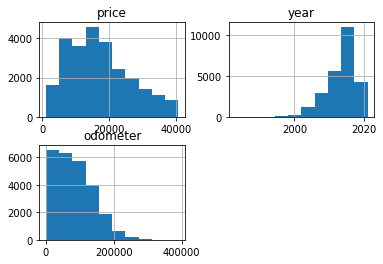

In [11]:
df[df['condition']=="null"].hist(bins=10)

In [12]:
onehot_these_columns.append("condition")

## Cylinders

In [13]:
df.groupby("cylinders")['price'].mean()

cylinders
10 cylinders    14549.672986
12 cylinders    10851.625000
3 cylinders     11303.132812
4 cylinders     10910.030387
5 cylinders      6950.400327
6 cylinders     13270.627364
8 cylinders     16473.431071
null            16542.824457
other           13574.572650
Name: price, dtype: float64

We have seen previously that most of the cylinders are either 4,6,8 or "null". Looking only at these categories, it seems that the trend is more the cylinders, higher the cost. So it might make sense to convert these categories to numbers instead of one-hot. There are very few cars with ['other',10,12,3,5] cyliners. We can convert the numbered categories to corresponding numbers and treat others as null.



**Other** *assign it the mean of all values* <br>
**null** *assign it the mean of all values*

<AxesSubplot:>

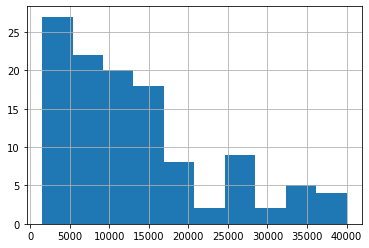

In [14]:
df[df['cylinders']=="other"]['price'].hist(bins=10)

In [15]:
mean_cylinder = (4+6+8)/3

replace_cylinders = {'3 cylinders':3, '4 cylinders':4, '5 cylinders':5, 
           '6 cylinders':6, '8 cylinders':8, '10 cylinders':10, 
           '12 cylinders':12, 'null':mean_cylinder, 'other':mean_cylinder}

df['cylinders'].replace(replace_cylinders, inplace=True)

In [16]:
df['cylinders'].unique()

array([ 6.,  4.,  8.,  5.,  3., 10., 12.])

## Fuel

In [17]:
df.groupby("fuel")['price'].agg([('mean'),('count')])

,mean,count
fuel,,
diesel,20854.858158,3941
electric,15166.683908,174
gas,13025.972290,75784
hybrid,11242.358569,1202
other,19159.013670,1902


Since there are only 5 categories, we can convert this column to dummy (onehot).

In [18]:
onehot_these_columns.append('fuel')

## Transmission

In [19]:
df.groupby("transmission")['price'].agg([('mean'),('count')])

,mean,count
transmission,,
automatic,13406.896059,74927
manual,10966.174769,4875
other,19976.082162,3201


Since there are only 3 unique values, we should convert this to dummy(onehot).

In [20]:
onehot_these_columns.append('transmission')

## Drive

In [21]:
df.groupby("drive")['price'].agg([('mean'),('count')])

,mean,count
drive,,
4wd,16590.406614,31841
fwd,10372.548913,38037
rwd,15173.048533,13125


Since there are only 3 unique values, we should convert this to dummy(onehot).

In [22]:
onehot_these_columns.append('drive')

## Type

In [23]:
df.groupby("type")['price'].agg([('mean'),('count')])

,mean,count
type,,
SUV,13817.498382,23799
bus,18051.030303,33
convertible,12887.358553,1520
coupe,15030.873151,3989
hatchback,8957.641141,3330
mini-van,9352.472274,2164
offroad,14647.139665,179
other,17443.189781,1644
pickup,20043.934753,7418


In [24]:
onehot_these_columns.append('type')

Since the price does fluctuate with the type of vehicle, this feature seems useful. Let's convert this to a dummy (onehot) as well.

## Paint

In [25]:
df.groupby("paint_color")['price'].agg([('mean'),('count')])

,mean,count
paint_color,,
black,14574.167654,15860
blue,11694.343485,8833
brown,10781.580084,1898
custom,14022.346578,3171
green,9246.564463,2133
grey,12753.835218,9376
orange,16363.644211,475
purple,9380.276151,239
red,12791.435066,8139


It looks like some colors are preferred over the others. Let's also convert this column to dummy(onehot).

In [26]:
onehot_these_columns.append('paint_color')

## State

In [27]:
usa = geopandas.read_file("data/maps/cb_2018_us_state_20m.shp")

usa['STUSPS'] = usa['STUSPS'].str.lower()
usa = usa[(usa['STUSPS']!='ak') & (usa['STUSPS']!='hi')]

state_df = df.groupby('state')['price'].agg(['mean', 'count'])

state_df = usa.merge(state_df, right_on="state", left_on="STUSPS")

state_df.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,mean,count
0,24,01714934,0400000US24,24,md,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",12705.338998,1118
1,19,01779785,0400000US19,19,ia,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",12341.300728,2198
2,10,01779781,0400000US10,10,de,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",12961.556420,257
3,39,01085497,0400000US39,39,oh,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",12131.137767,3985
4,42,01779798,0400000US42,42,pa,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",11128.381918,2909


Text(0.5, 1.0, 'State-wise Mean Selling Price')

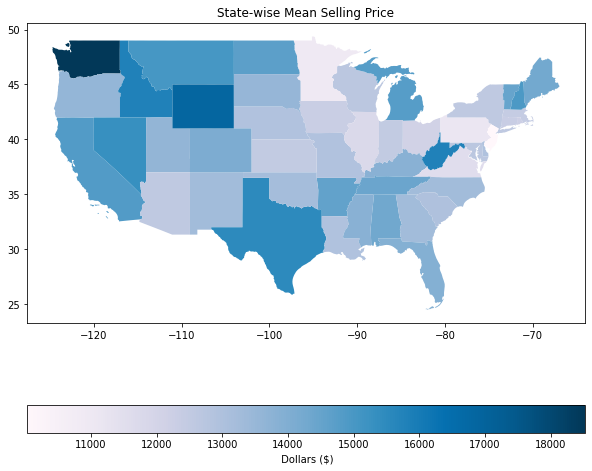

In [28]:
fig, ax = plt.subplots(1, 1,figsize=(10,10))
legend = {'label':" Dollars ($)", 'orientation': "horizontal"}
state_df.plot(column="mean", ax=ax, legend=True, legend_kwds=legend, cmap="PuBu")
plt.title("State-wise Mean Selling Price")


In [29]:
def set_graph_text_color(COLOR):
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR
    mpl.rcParams['legend.fontsize'] = 'large'
    mpl.rcParams['axes.titlesize'] = 18
    mpl.rcParams['legend.facecolor'] = 'cornflowerblue'

In [30]:
print(df[df['state']=='wa'].agg('mean'))
print(df[df['state']=='mn'].agg('mean'))

price        18519.010095
year          2012.121136
cylinders        5.692114
odometer     89235.920505
dtype: float64
price         10932.005498
year           2010.298717
cylinders         5.727550
odometer     118233.042150
dtype: float64


In [31]:
# df[(df['state']=="wa") | (df['state']=="mn")].groupby(["state", "type"])['price'].agg([('mean'),('count')])
minnesota = df[df['state']=="mn"].groupby('type')['price'].agg(['mean','count'])
minnesota.rename(columns={"mean":"mn_mean","count":"mn_count"}, inplace=True)

washington = df[df['state']=="wa"].groupby('type')['price'].agg(['mean','count'])
washington.rename(columns={"mean":"wa_mean","count":"wa_count"}, inplace=True)

state_type_comp = minnesota.merge(washington, on="type", how="inner")
state_type_comp

,mn_mean,mn_count,wa_mean,wa_count
type,,,,
SUV,12593.358065,620,20800.498069,518
convertible,9776.666667,21,14265.117647,17
coupe,6663.888889,36,15804.371795,78
hatchback,7169.679245,53,9966.706897,58
mini-van,8560.000000,58,12544.581395,43
other,2700.000000,2,8138.500000,6
pickup,12681.963190,163,19008.378378,74
sedan,7799.785563,471,13120.923611,432
truck,14129.858268,127,28283.959854,274


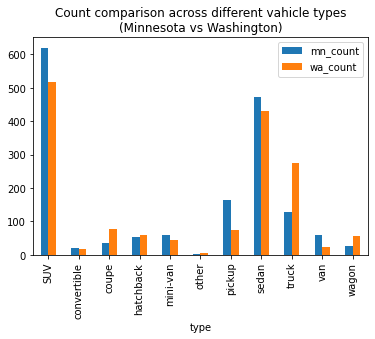

In [32]:
# set_graph_text_color('white')
state_type_comp.plot(y=['mn_count',"wa_count"], kind="bar",
                    title="Count comparison across different vahicle types\n(Minnesota vs Washington)")
set_graph_text_color('black')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'SUV'),
  Text(1, 0, 'convertible'),
  Text(2, 0, 'coupe'),
  Text(3, 0, 'hatchback'),
  Text(4, 0, 'mini-van'),
  Text(5, 0, 'other'),
  Text(6, 0, 'pickup'),
  Text(7, 0, 'sedan'),
  Text(8, 0, 'truck'),
  Text(9, 0, 'van'),
  Text(10, 0, 'wagon')])

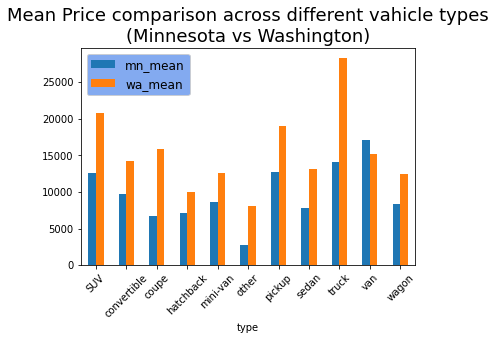

In [33]:
# set_graph_text_color('white')
state_type_comp.plot(y=['mn_mean',"wa_mean"], kind="bar", 
                     title="Mean Price comparison across different vahicle types\n(Minnesota vs Washington)")
set_graph_text_color('black')
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'SUV'),
  Text(1, 0, 'convertible'),
  Text(2, 0, 'coupe'),
  Text(3, 0, 'hatchback'),
  Text(4, 0, 'mini-van'),
  Text(5, 0, 'other'),
  Text(6, 0, 'pickup'),
  Text(7, 0, 'sedan'),
  Text(8, 0, 'truck'),
  Text(9, 0, 'van'),
  Text(10, 0, 'wagon')])

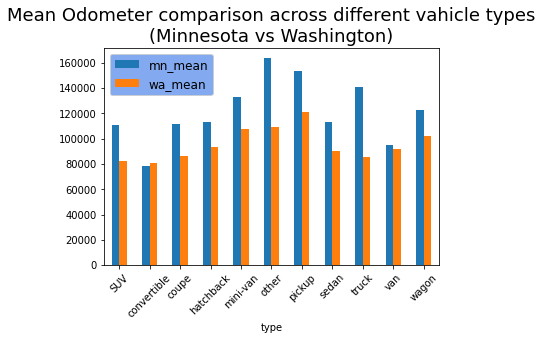

In [34]:
# df[(df['state']=="wa") | (df['state']=="mn")].groupby(["state", "type"])['price'].agg([('mean'),('count')])
minnesota = df[df['state']=="mn"].groupby('type')['odometer'].agg(['mean','count'])
minnesota.rename(columns={"mean":"mn_mean","count":"mn_count"}, inplace=True)

washington = df[df['state']=="wa"].groupby('type')['odometer'].agg(['mean','count'])
washington.rename(columns={"mean":"wa_mean","count":"wa_count"}, inplace=True)

state_type_comp = minnesota.merge(washington, on="type", how="inner")

# set_graph_text_color('white')
state_type_comp.plot(y=['mn_mean',"wa_mean"], kind="bar", 
                     title="Mean Odometer comparison across different vahicle types\n(Minnesota vs Washington)")
set_graph_text_color('black')
plt.xticks(rotation=45)

In [35]:
df.groupby("state")['price'].agg([('mean'),('count')]).head()

,mean,count
state,,
ak,18272.636199,1105
al,14327.241065,1427
ar,14580.399110,674
az,12604.070473,1121
ca,14843.310898,6359


The prices of the used cars vary from one state to another. But it is hard to tell if it will play an important role in building the model for now.

In [36]:
method = "bucket"
if method=="bucket":
    state_buckets = {}
    for k,v in dict(df.groupby("state")['price'].mean()).items():
        state_buckets[k] = int(v/1000)

    df['state'].replace(state_buckets, inplace=True)
    print(df['state'].unique())
elif method=="onehot":
    onehot_these_columns.append('state')
else:
    delete_these_columns.append('state')
    

[10 13 12 15 11 18 14 16]


## Year

In [37]:
df['year'].describe()

count    83003.000000
mean      2011.128610
std          5.800385
min       1981.000000
25%       2007.000000
50%       2012.000000
75%       2016.000000
max       2021.000000
Name: year, dtype: float64

In [38]:
df['year'].min()

1981.0

In [39]:
df['year_count'] = df['year']-df['year'].min()
delete_these_columns.append('year')

<AxesSubplot:xlabel='year'>

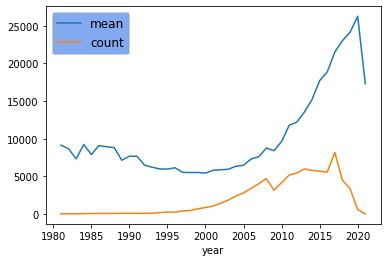

In [40]:
df.groupby('year')['price'].agg([('mean'),('count')]).plot()

## Drop columns

In [41]:
print("We will delete these columns: ", delete_these_columns)

We will delete these columns:  ['model', 'year']


In [42]:
df.drop(columns=delete_these_columns, axis=1, inplace=True)

## Correlations

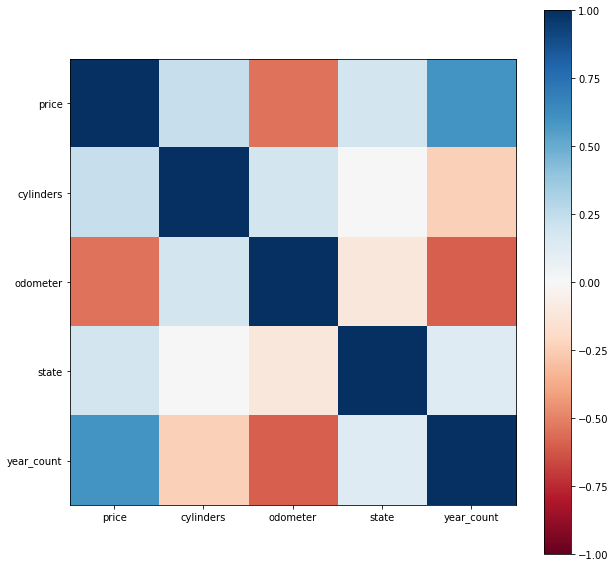

In [43]:
corr_matrix= df.corr()

# set_graph_text_color('white')

fig_cor, axes_cor = plt.subplots(1,1)
fig_cor.set_size_inches(10, 10)

labels = df.select_dtypes(include=np.number).columns.tolist()

myimage = axes_cor.imshow(corr_matrix, cmap="RdBu", vmin=-1)
# plt.pcolor()
plt.colorbar(myimage)

axes_cor.set_xticks(np.arange(0,corr_matrix.shape[0], corr_matrix.shape[0]*1.0/len(labels)))
axes_cor.set_yticks(np.arange(0,corr_matrix.shape[1], corr_matrix.shape[1]*1.0/len(labels)))

axes_cor.set_xticklabels(labels)
axes_cor.set_yticklabels(labels)

plt.draw()

## Convert to onehot/dummy

In [44]:
print("We want to convert these columns into onehot:\n", onehot_these_columns)


We want to convert these columns into onehot:
 ['manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type', 'paint_color']


In [45]:
df_dummy = pd.get_dummies(df, columns=onehot_these_columns)

In [46]:
df_dummy.head()

,price,cylinders,odometer,state,year_count,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_audi,manufacturer_bmw,manufacturer_buick,...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
0,13995,6.0,188406.0,10,31.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,7995,4.0,108124.0,10,29.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,8995,6.0,178054.0,10,30.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,10995,6.0,170259.0,10,33.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,12995,6.0,309621.0,10,23.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [47]:
df_dummy.dtypes

price                   int64
cylinders             float64
odometer              float64
state                   int64
year_count            float64
                       ...   
paint_color_purple      uint8
paint_color_red         uint8
paint_color_silver      uint8
paint_color_white       uint8
paint_color_yellow      uint8
Length: 85, dtype: object

## Insight of the Price

In [48]:
df_dummy['price'].value_counts()

6995     923
7995     895
8995     844
3500     817
5995     776
        ... 
11745      1
13794      1
30186      1
32235      1
18441      1
Name: price, Length: 7850, dtype: int64

In [49]:
print(df_dummy['price'].max())
print(df_dummy['price'].min())

40712
1050


-----
# Model
-----

In [50]:
model_results = dict()
model_names = ['Linear Regression', 'Extra Trees Regression', 
               'Bagging Regression', 'Ridge Regression', 'AdaBoost Regression', 
               'Decision Tree Regression']

In [51]:
y = df_dummy['price']
X = df_dummy.drop(columns=['price'])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, shuffle=True)

In [53]:
len(X_train), len(X_test)

(74702, 8301)

In [54]:
def loss_MSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5


# find whether our prediction is correct within a certain threshold
def accuracy(y_true, y_pred, thresh=100):
    return np.sum(np.where(abs(y_true-y_pred)<thresh, 1, 0)) / len(y_true)

def acc_r2(y_true, y_pred):
    return round(r2_score(y_true, y_pred) * 100, 2)

def printResults(model, y_train, y_test, y_pred_train, y_pred_test, threshold):
    mse_train = loss_MSE(y_train, y_pred_train)
    mse_test = loss_MSE(y_test, y_pred_test)
    acc_train = accuracy(y_train, y_pred_train, threshold)
    acc_test = accuracy(y_test, y_pred_test, threshold)
    r2_train = acc_r2(y_train, y_pred_train)
    r2_test = acc_r2(y_test, y_pred_test)
    # save results
    model_results[model] = [mse_train, mse_test, acc_train, acc_test, r2_train, r2_test]
    print("Loss MSE(Train): ", mse_train)
    print("Loss MSE(Test): ", mse_test)
    print("Accuracy with threshold =", threshold, "(Train):", acc_train)
    print("Accuracy with threshold =", threshold, "(Test):", acc_test)
    print("R2 Score(Train): ", r2_train)
    print("R2 Score(Test): ", r2_test)

In [55]:
threshold = 2000

### Linear Regression

In [56]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [57]:
y_pred_train = model_lr.predict(X_train)
y_pred_test = model_lr.predict(X_test)
printResults(model_names[0], y_train, y_test, y_pred_train, y_pred_test, threshold)

Loss MSE(Train):  4543.158229081127
Loss MSE(Test):  4528.010426508103
Accuracy with threshold = 2000 (Train): 0.3974726245615914
Accuracy with threshold = 2000 (Test): 0.41163715215034336
R2 Score(Train):  74.41
R2 Score(Test):  74.0


### Extra Trees Regression

In [58]:
model_etr = ExtraTreesRegressor(max_depth=18)
# model_etr = ExtraTreesRegressor()
model_etr.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=18)

In [59]:
y_pred_train = model_etr.predict(X_train)
y_pred_test = model_etr.predict(X_test)
printResults(model_names[1], y_train, y_test, y_pred_train, y_pred_test, threshold)

Loss MSE(Train):  1878.2874651951215
Loss MSE(Test):  3083.06476107068
Accuracy with threshold = 2000 (Train): 0.804891435302937
Accuracy with threshold = 2000 (Test): 0.6520901096253463
R2 Score(Train):  95.63
R2 Score(Test):  87.95


### Bagging Regression

In [60]:
model_bagging = BaggingRegressor()
model_bagging.fit(X_train, y_train)

BaggingRegressor()

In [61]:
y_pred_train = model_bagging.predict(X_train)
y_pred_test = model_bagging.predict(X_test)
printResults(model_names[2], y_train, y_test, y_pred_train, y_pred_test, threshold)

Loss MSE(Train):  1349.5174620808073
Loss MSE(Test):  3237.2480392014245
Accuracy with threshold = 2000 (Train): 0.8988112768065112
Accuracy with threshold = 2000 (Test): 0.646669076014938
R2 Score(Train):  97.74
R2 Score(Test):  86.71


### Ridge Regression

In [62]:
model_rcv = RidgeCV()
model_rcv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [63]:
y_pred_train = model_rcv.predict(X_train)
y_pred_test = model_rcv.predict(X_test)
printResults(model_names[3], y_train, y_test, y_pred_train, y_pred_test, threshold)

Loss MSE(Train):  4551.93498012476
Loss MSE(Test):  4535.607773274533
Accuracy with threshold = 2000 (Train): 0.39909239377794437
Accuracy with threshold = 2000 (Test): 0.41211902180460186
R2 Score(Train):  74.31
R2 Score(Test):  73.91


### AdaBoost Regression

In [64]:
model_adaboost = AdaBoostRegressor()
model_adaboost.fit(X_train, y_train)

AdaBoostRegressor()

In [65]:
y_pred_train = model_adaboost.predict(X_train)
y_pred_test = model_adaboost.predict(X_test)
printResults(model_names[4], y_train, y_test, y_pred_train, y_pred_test, threshold)

Loss MSE(Train):  5679.408341296735
Loss MSE(Test):  5680.359646623177
Accuracy with threshold = 2000 (Train): 0.19597868865626086
Accuracy with threshold = 2000 (Test): 0.20455366823274304
R2 Score(Train):  60.01
R2 Score(Test):  59.08


### Decision Tree Regression

In [66]:
model_dt = DecisionTreeRegressor(max_depth=15)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=15)

In [67]:
y_pred_train = model_dt.predict(X_train)
y_pred_test = model_dt.predict(X_test)
printResults(model_names[5], y_train, y_test, y_pred_train, y_pred_test, threshold)

Loss MSE(Train):  2681.7013428546065
Loss MSE(Test):  3837.879988069226
Accuracy with threshold = 2000 (Train): 0.6906910122888276
Accuracy with threshold = 2000 (Test): 0.5854716299241055
R2 Score(Train):  91.08
R2 Score(Test):  81.32


## Comparison of models

In [68]:
mse_train = []
mse_test = []
acc_train = []
acc_test = []
r2_train = []
r2_test = []

for name in model_names:
    res = model_results[name]
    mse_train.append(res[0])
    mse_test.append(res[1])
    acc_train.append(res[2])
    acc_test.append(res[3])
    r2_train.append(res[4])
    r2_test.append(res[5])
    
models = pd.DataFrame({
    'model': model_names,
    'mse_train': mse_train,
    'mse_test': mse_test,
    'acc_train': acc_train,
    'acc_test': acc_test,
    'r2_train': r2_train,
    'r2_test': r2_test
                     })

### Mean Square Error

In [69]:
# plt.figure(figsize=[16,6])
# xx = models['model']
# plt.tick_params(labelsize=14)
# plt.plot(xx, models['mse_train'], label = 'mse_train')
# plt.plot(xx, models['mse_test'], label = 'mse_test')
# plt.legend()
# plt.title('Mean Square Error for 6 models on train and test set.')
# plt.xlabel('Models')
# plt.ylabel('MSE')
# plt.xticks(xx, rotation='vertical')
# plt.show()

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Linear Regression'),
  Text(1, 0, 'Extra Trees Regression'),
  Text(2, 0, 'Bagging Regression'),
  Text(3, 0, 'Ridge Regression'),
  Text(4, 0, 'AdaBoost Regression'),
  Text(5, 0, 'Decision Tree Regression')])

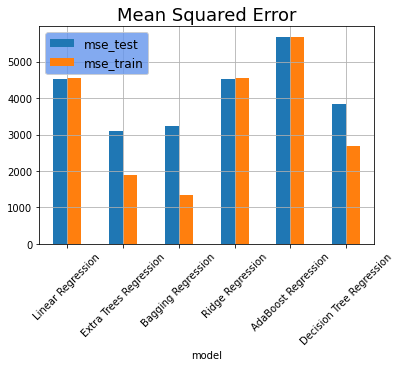

In [70]:
# set_graph_text_color('white')
models.set_index('model')[['mse_test','mse_train']].plot(kind='bar', grid=True, title='Mean Squared Error')
# set_graph_text_color('black')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Linear Regression'),
  Text(1, 0, 'Extra Trees Regression'),
  Text(2, 0, 'Bagging Regression'),
  Text(3, 0, 'Ridge Regression'),
  Text(4, 0, 'AdaBoost Regression'),
  Text(5, 0, 'Decision Tree Regression')])

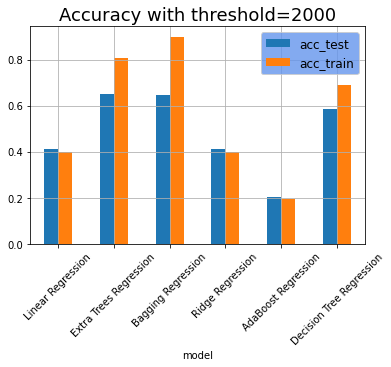

In [71]:
# set_graph_text_color('white')
models.set_index('model')[['acc_test','acc_train']].plot(kind='bar', grid=True, title='Accuracy with threshold=2000')
set_graph_text_color('black')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Linear Regression'),
  Text(1, 0, 'Extra Trees Regression'),
  Text(2, 0, 'Bagging Regression'),
  Text(3, 0, 'Ridge Regression'),
  Text(4, 0, 'AdaBoost Regression'),
  Text(5, 0, 'Decision Tree Regression')])

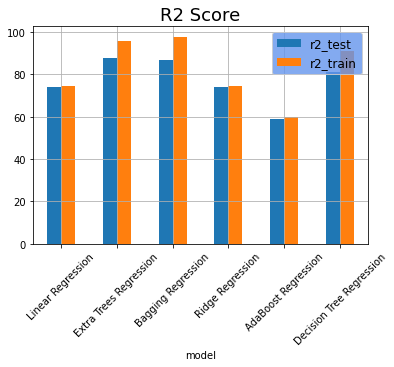

In [72]:
# set_graph_text_color('white')
models.set_index('model')[['r2_test','r2_train']].plot(kind='bar', grid=True, title='R2 Score')
set_graph_text_color('black')
plt.xticks(rotation=45)

### Accuracy with threshold

In [73]:
# plt.figure(figsize=[16,6])
# xx = models['model']
# plt.tick_params(labelsize=14)
# plt.plot(xx, models['acc_train'], label = 'acc_train')
# plt.plot(xx, models['acc_test'], label = 'acc_test')
# plt.legend()
# plt.title('Accuracy with threshold ='+str(threshold)+'for 6 models on train and test set.')
# plt.xlabel('Models')
# plt.ylabel('Accuracy with threshold ='+str(threshold))
# plt.xticks(xx, rotation='vertical')
# plt.show()

### R2 Score

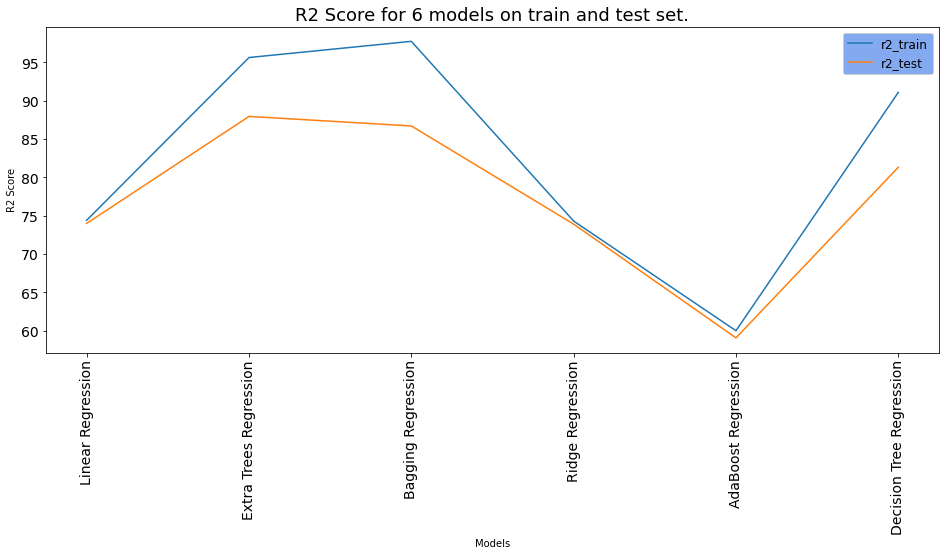

In [74]:
plt.figure(figsize=[16,6])
xx = models['model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['r2_train'], label = 'r2_train')
plt.plot(xx, models['r2_test'], label = 'r2_test')
plt.legend()
plt.title('R2 Score for 6 models on train and test set.')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.xticks(xx, rotation='vertical')
plt.show()

# Prediction

From the results of the last section, we conclude that the Extra Trees Regression performs the best among the regression models.
So in this part, we will choose to use it to perform the prediction.

In [75]:
used_car = pd.DataFrame().reindex_like(X_test)[:1]
used_car['manufacturer'] = "honda"
used_car['manufacturer'].replace(price_buckets, inplace=True)
used_car['cylinders'] = 12.0
used_car['odometer'] = 100000.0
used_car['year_count'] = 2010-1980
used_car['condition_excellent'] = 1
used_car['condition_fair'] = 0
used_car['condition_good'] = 0
used_car['condition_like new'] = 0
used_car['condition_new'] = 0
used_car['condition_null'] = 0
used_car['condition_salvage'] = 0
used_car['fuel_diesel'] = 0
used_car['fuel_electric'] = 0
used_car['fuel_gas'] = 1
used_car['fuel_hybrid'] = 0
used_car['fuel_other'] = 0
used_car['transmission_automatic'] = 1
used_car['transmission_manual'] = 0
used_car['transmission_other'] = 0
used_car['drive_4wd'] = 0
used_car['drive_fwd'] = 1
used_car['drive_rwd'] = 0
used_car['type_SUV'] = 0
used_car['type_bus'] = 0
used_car['type_convertible'] = 0
used_car['type_coupe'] = 0
used_car['type_hatchback'] = 0
used_car['type_mini-van'] = 0
used_car['type_offroad'] = 0
used_car['type_other'] = 0
used_car['type_pickup'] = 0
used_car['type_sedan'] = 1
used_car['type_truck'] = 0
used_car['type_van'] = 0
used_car['type_wagon'] = 0

y_pred_test = model_etr.predict(used_car)
print("Car's value:", y_pred_test)

NameError: name 'price_buckets' is not defined

In [ ]:
79, 65